# Quadkey Validation Practice

### Is the quadkey geospatial index we can calculate equal to the quadkey used by OOKLA?

This notebook demonstrates a process to validate that the Quadkey from the OOKLA data matches the Quadkey returned by the Mercantile function. The following steps are performed:

1. Load the necessary libraries and data.
2. Generate quadkeys and geometries for a given polygon.
3. Plot the generated quadkeys.
4. Validate the consistency of quadkeys between OOKLA data and Mercantile function.


In [49]:
import mercantile
from shapely.geometry import shape, box, Polygon
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown



## Load Data
Load the geometries for MI Eastern Upper Peninsula and OOKLA tiles data.

In [21]:
cld_gdf = gpd.read_file('../../DATA/EUPCounties.shp.zip')
ookla_tiles_df = pd.read_csv('../../tiles.csv')

In [22]:
# Explode the GeoDataFrame
exploded_gdf = cld_gdf.explode(index_parts=True)

# Reset index to clean up the DataFrame
cld_gdf = exploded_gdf.reset_index(drop=True)
def get_polygon_coordinates(geometry):
    if geometry.geom_type == 'Polygon':
        return list(geometry.exterior.coords)
    elif geometry.geom_type == 'MultiPolygon':
        coords = []
        for poly in geometry:
            coords.extend(list(poly.exterior.coords))
        return coords
    else:
        return []

# Apply the function to the geometry column
cld_gdf['coordinates'] = cld_gdf['geometry'].apply(get_polygon_coordinates)

# Display the first few rows with coordinates
print(cld_gdf[['geometry', 'coordinates']].head())

                                            geometry  \
0  POLYGON ((-83.93101 46.05865, -83.92995 46.058...   
1  POLYGON ((-83.64061 45.9499, -83.64051 45.9499...   
2  POLYGON ((-83.8265 45.94163, -83.82784 45.9412...   
3  POLYGON ((-83.56223 45.91343, -83.56209 45.913...   
4  POLYGON ((-83.81695 45.9559, -83.81716 45.9551...   

                                         coordinates  
0  [(-83.93100779135577, 46.05864964297757), (-83...  
1  [(-83.64061328928217, 45.94989661245215), (-83...  
2  [(-83.82650046189264, 45.94163158575794), (-83...  
3  [(-83.56223460251469, 45.91342849264217), (-83...  
4  [(-83.81694668031835, 45.955899082544924), (-8...  


<Axes: >

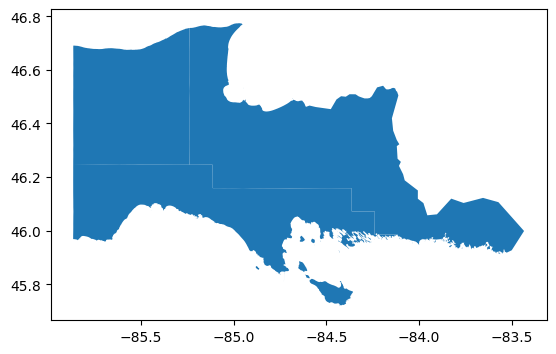

In [23]:
cld_gdf.plot()

## Generate Quadkeys and Geometries
Generate all quadkeys and geometries at a specific resolution within a geographic area defined by a polygon.

In [24]:
def generate_quadkeys_and_geometries(polygon, zoom):
    """
    Generate all quadkeys and geometries at a specific resolution within a geographic area defined by a polygon.

    Parameters:
    polygon (Polygon): Shapely Polygon object defining the geographic area
    zoom (int): Zoom level for the quadkeys

    Returns:
    GeoDataFrame: GeoDataFrame containing quadkeys and geometries
    """
    min_lon, min_lat, max_lon, max_lat = polygon.bounds
    tiles = list(mercantile.tiles(min_lon, min_lat, max_lon, max_lat, zoom))

    quadkeys = []
    geometries = []

    for tile in tiles:
        tile_geom = box(*mercantile.bounds(tile))
        if polygon.intersects(tile_geom):
            quadkeys.append(mercantile.quadkey(tile))
            geometries.append(tile_geom)

    gdf = gpd.GeoDataFrame({'quadkey': quadkeys, 'geometry': geometries})
    return gdf.set_crs(epsg=4326)

# Example usage
# polygon_coords = [(-83.0, 42.0), (-83.0, 43.0), (-82.0, 43.0), (-82.0, 42.0), (-83.0, 42.0)]
# polygon = Polygon(polygon_coords)

zoom = 16  # Replace with your desired zoom level OOKLA is using 16


quadkey_gdf = gpd.GeoDataFrame()
for index, row in cld_gdf.iterrows():
    temp_gdf = generate_quadkeys_and_geometries(row['geometry'], zoom)
    quadkey_gdf = pd.concat([quadkey_gdf, temp_gdf])
# Display the first few rows of the quadkey GeoDataFrame
print(quadkey_gdf.head())


            quadkey                                           geometry
0  0302203103102032  POLYGON ((-85.23743 46.75492, -85.23743 46.758...
1  0302203103102210  POLYGON ((-85.23743 46.75115, -85.23743 46.754...
2  0302203103102212  POLYGON ((-85.23743 46.74739, -85.23743 46.751...
3  0302203103102230  POLYGON ((-85.23743 46.74362, -85.23743 46.747...
4  0302203103102232  POLYGON ((-85.23743 46.73986, -85.23743 46.743...


<Axes: >

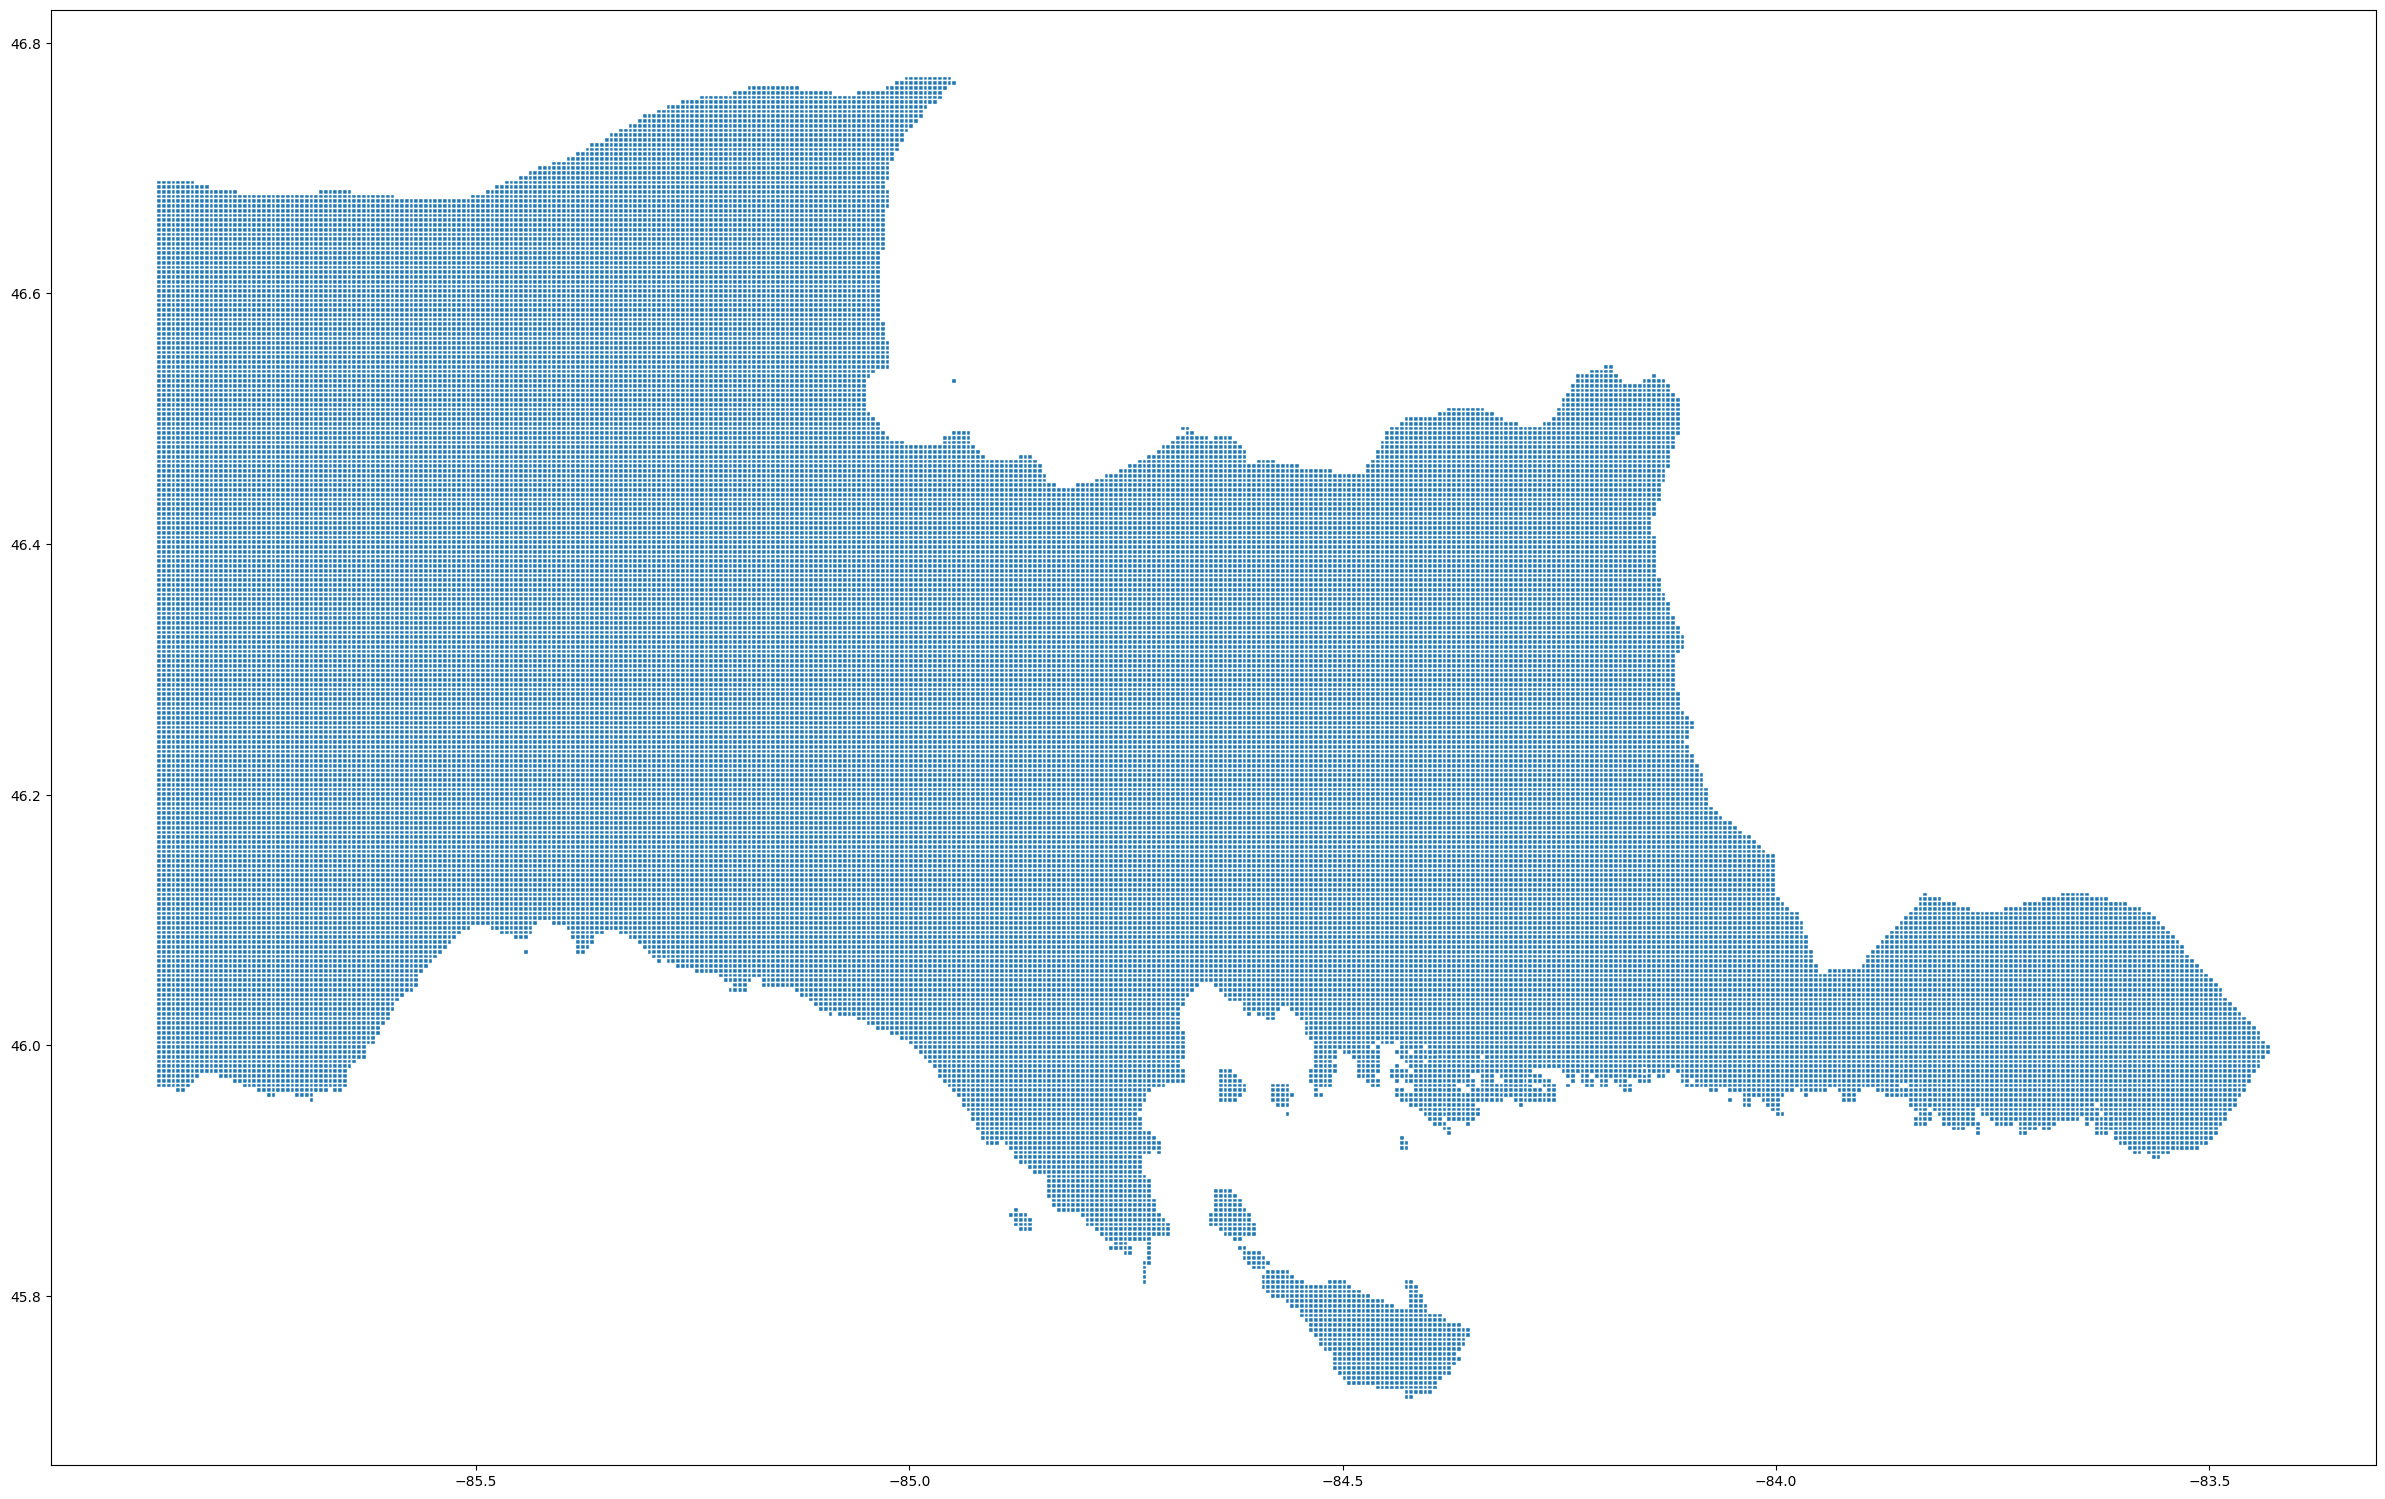

In [25]:
quadkey_gdf.plot(figsize=(30, 40), edgecolor='white')

## Visualize the OOKLA Tiles

In [34]:
ookla_tiles_df

,quadkey,tile,tile_x,tile_y,avg_d_kbps,avg_u_kbps,avg_lat_ms,avg_lat_down_ms,avg_lat_up_ms,tests,devices,quarter
0,213311131333300,"POLYGON((-90.02197265625 48.2393089902491, -90...",-90.0192,48.2375,48081,21212,36,94.0,94.0,1,1,2024Q2
1,213311132312300,"POLYGON((-90.41748046875 48.0633965377621, -90...",-90.4147,48.0616,112863,92237,15,481.0,104.0,1,1,2024Q2
2,213311132312301,"POLYGON((-90.4119873046875 48.0633965377621, -...",-90.4092,48.0616,236775,256004,14,22.0,31.0,1,1,2024Q2
3,213311132313030,"POLYGON((-90.384521484375 48.0707382642583, -9...",-90.3818,48.0689,9877,18935,35,496.0,451.0,2,2,2024Q2
4,213311132313100,"POLYGON((-90.37353515625 48.0780789434986, -90...",-90.3708,48.0762,115923,129411,13,85.0,96.0,8,1,2024Q2
...,...,...,...,...,...,...,...,...,...,...,...,...
112347,302232302111112,"POLYGON((-82.628173828125 41.7672146942102, -8...",-82.6254,41.7652,80160,15194,42,110.0,52.0,3,1,2024Q2
112348,302232302111130,"POLYGON((-82.628173828125 41.7631174470059, -8...",-82.6254,41.7611,140824,9282,30,1511.0,1872.0,2,1,2024Q2
112349,302232302111132,"POLYGON((-82.628173828125 41.7590199381554, -8...",-82.6254,41.7570,100143,19181,46,102.0,70.0,2,1,2024Q2
112350,302232302111311,"POLYGON((-82.6226806640625 41.754922167663, -8...",-82.6199,41.7529,87613,7456,53,231.0,115.0,1,1,2024Q2


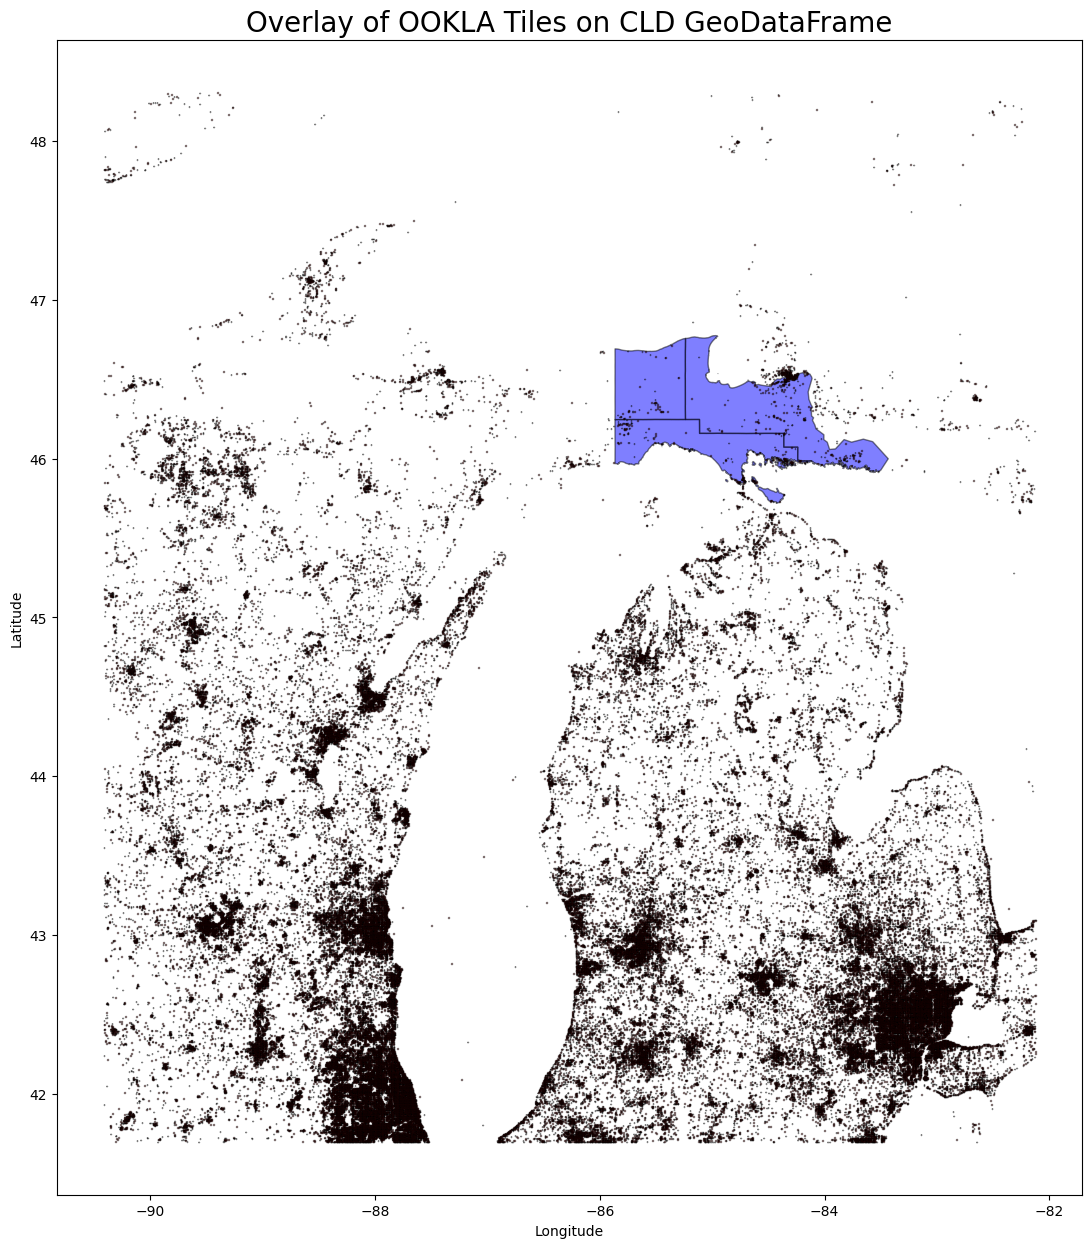

In [35]:
# Convert the ookla_tiles_df to a GeoDataFrame
ookla_tiles_gdf = gpd.GeoDataFrame(ookla_tiles_df, geometry=gpd.GeoSeries.from_wkt(ookla_tiles_df['tile']))

# Ensure both GeoDataFrames have the same CRS
ookla_tiles_gdf = ookla_tiles_gdf.set_crs(epsg=4326)
cld_gdf = cld_gdf.set_crs(epsg=4326)

# Plot the cld_gdf
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
cld_gdf.plot(ax=ax, color='blue', edgecolor='black', alpha=0.5)

# Overlay the ookla_tiles_gdf
ookla_tiles_gdf.plot(ax=ax, color='red', edgecolor='black', alpha=0.5)

# Set plot title and labels
ax.set_title('Overlay of OOKLA Tiles on CLD GeoDataFrame', fontsize=20)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

In [ ]:
# Convert the ookla_tiles_df to a GeoDataFrame
ookla_tiles_gdf = gpd.GeoDataFrame(ookla_tiles_df, geometry=gpd.GeoSeries.from_wkt(ookla_tiles_df['tile']))

# Ensure both GeoDataFrames have the same CRS
ookla_tiles_gdf = ookla_tiles_gdf.set_crs(epsg=4326)
cld_gdf = cld_gdf.set_crs(epsg=4326)

# Perform spatial join
joined_gdf = gpd.sjoin(cld_gdf, ookla_tiles_gdf, how="inner", op='intersects')

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
cld_gdf.plot(ax=ax, color='blue', edgecolor='black', alpha=0.5)
joined_gdf.plot(ax=ax, color='red', edgecolor='black', alpha=0.5)

# Set plot title and labels
ax.set_title('Overlay of OOKLA Tiles (Red) that Intersect CLD Areas (Blue)', fontsize=20)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

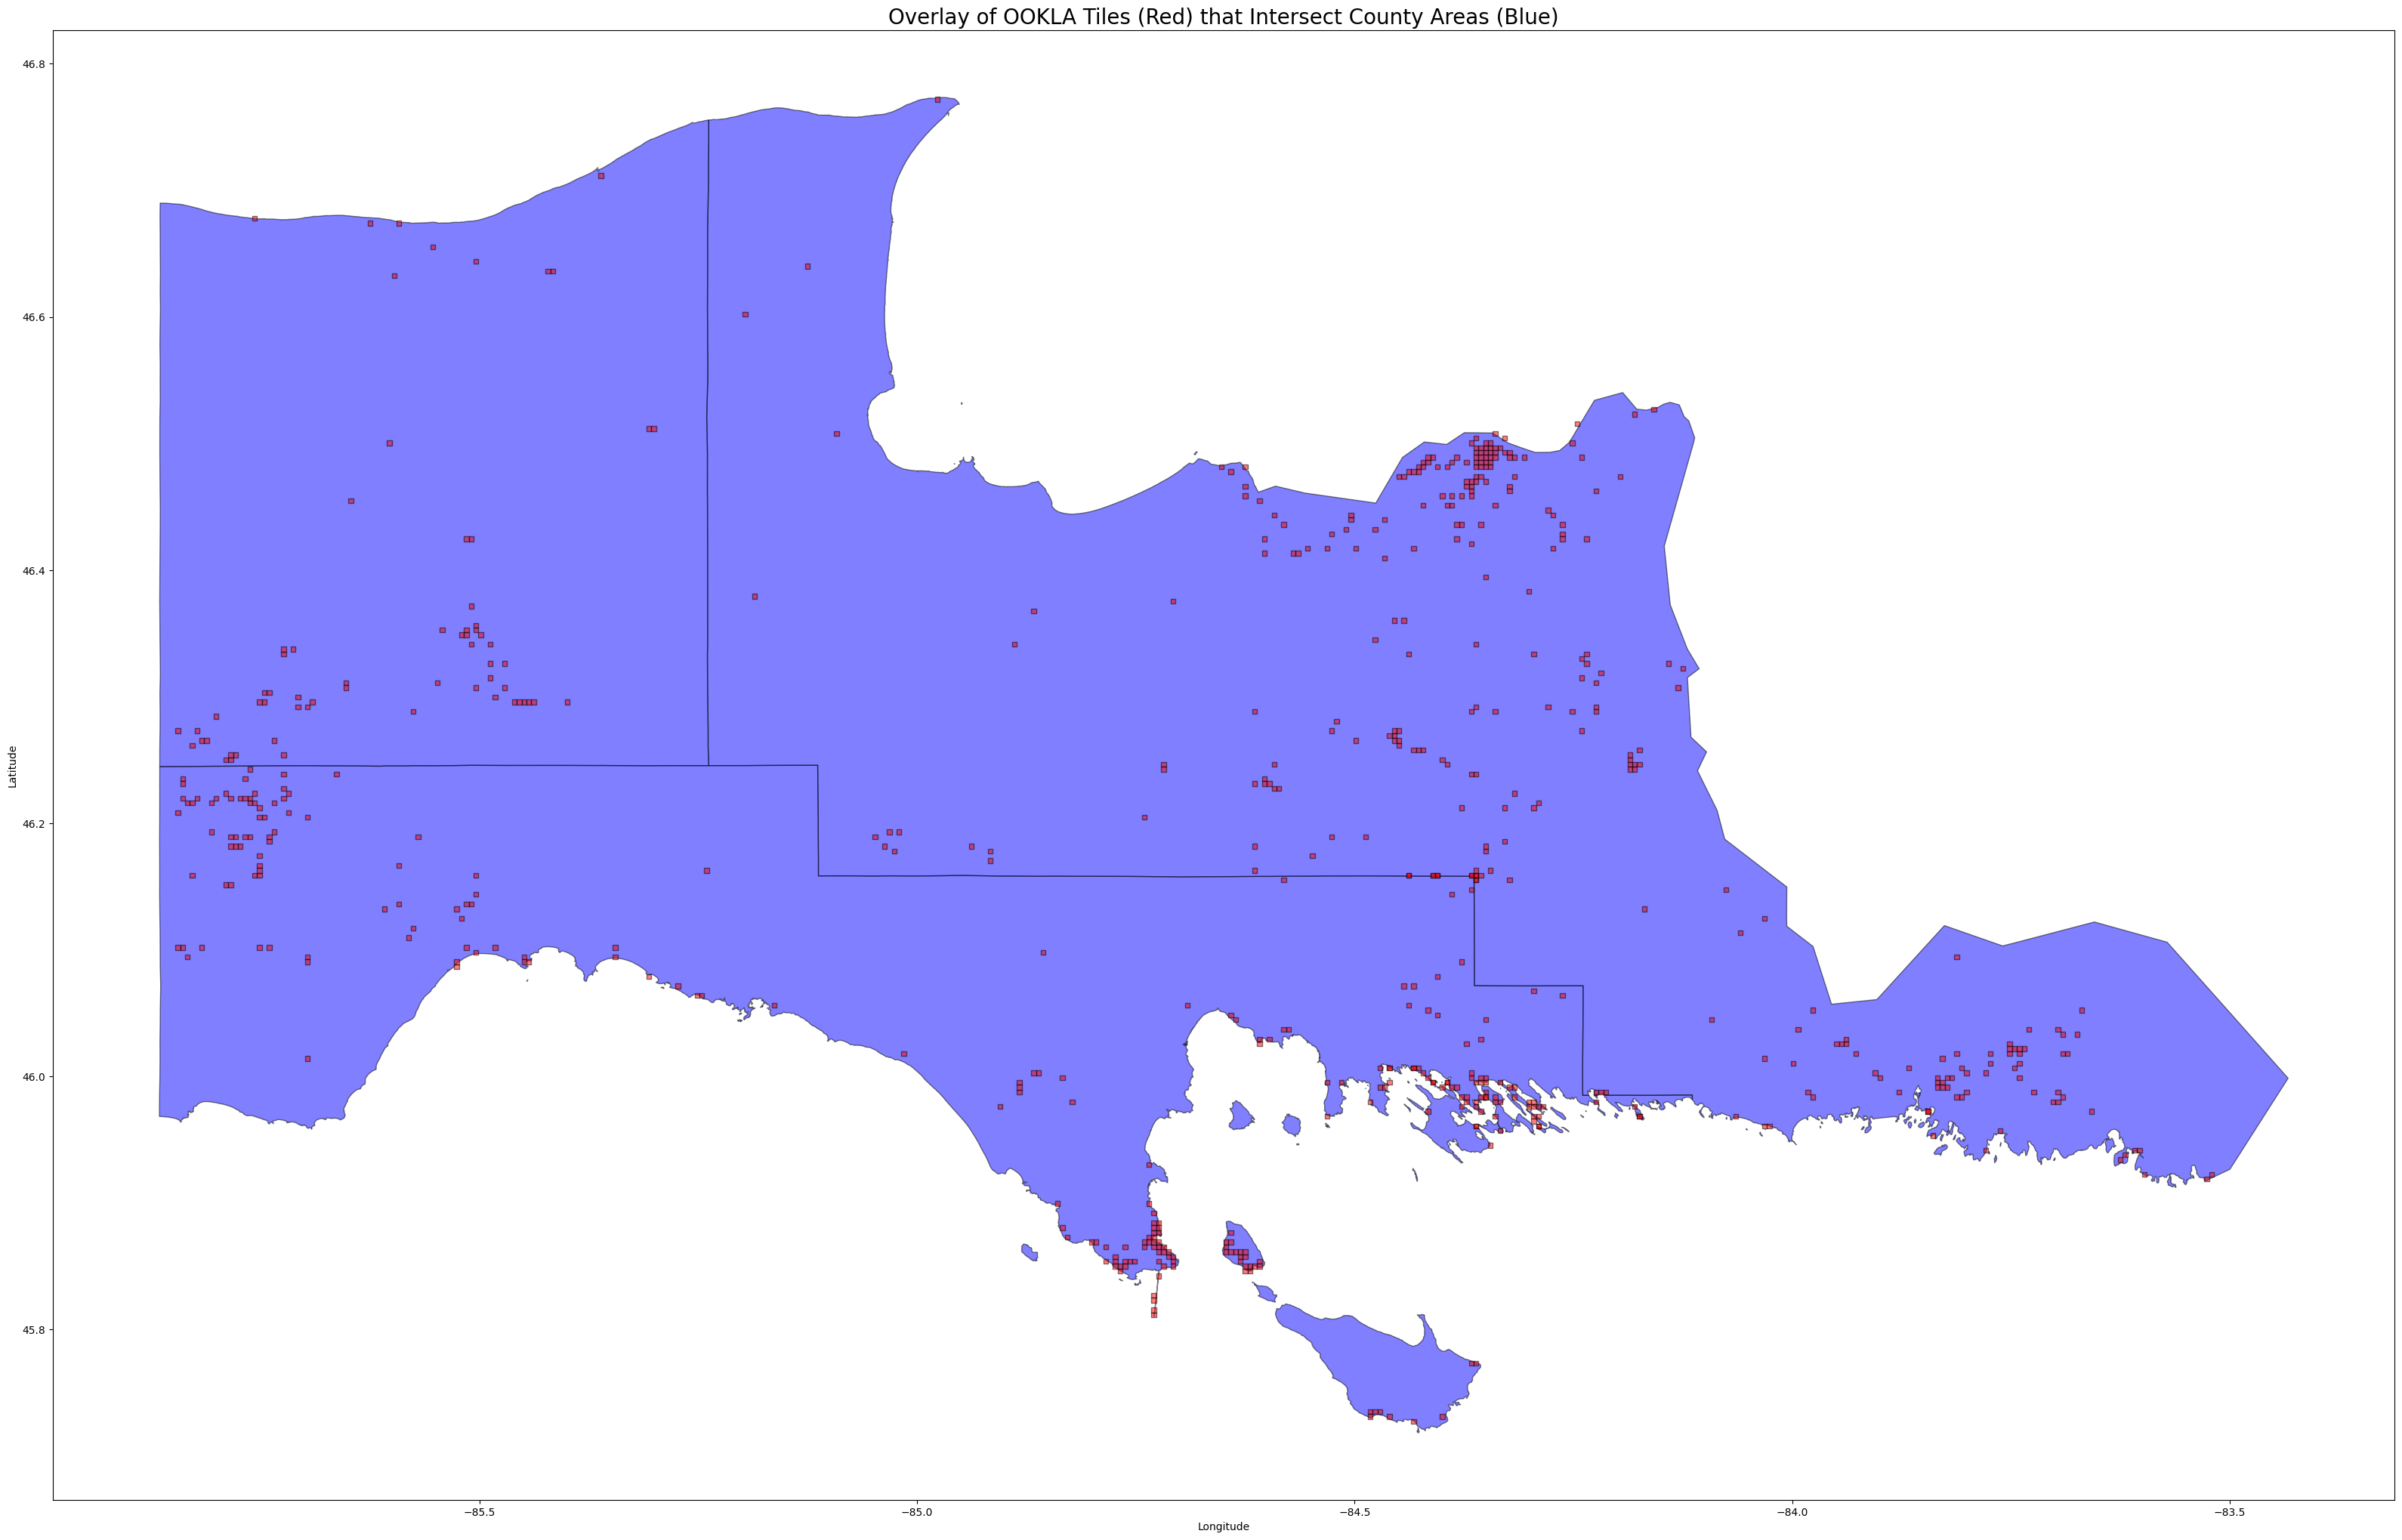

In [ ]:
# Convert the ookla_tiles_df to a GeoDataFrame
ookla_tiles_gdf = gpd.GeoDataFrame(ookla_tiles_df, geometry=gpd.GeoSeries.from_wkt(ookla_tiles_df['tile']))

# Ensure both GeoDataFrames have the same CRS
ookla_tiles_gdf = ookla_tiles_gdf.set_crs(epsg=4326)
cld_gdf = cld_gdf.set_crs(epsg=4326)

# Perform spatial join
joined_gdf = gpd.sjoin(ookla_tiles_gdf, cld_gdf, how="inner", predicate='intersects')

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(40, 40))
cld_gdf.plot(ax=ax, color='blue', edgecolor='black', alpha=0.5)
joined_gdf.plot(ax=ax, color='red', edgecolor='black', alpha=0.5)

# Set plot title and labels
ax.set_title('Overlay of OOKLA Tiles (Red) that Intersect County Areas (Blue)', fontsize=20)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

In [36]:
#quadkey_gdf

### Validation Test: Verifying Quadkey Consistency

This validation test ensures that the Quadkey from the OOKLA data matches the Quadkey returned by the Mercantile function. The following steps are performed:

1. Convert the 'quadkey' column to integers in both DataFrames.
2. Perform a left join based on the 'quadkey' column.
3. Convert the merged DataFrame back to a GeoDataFrame if needed.
4. Create a new column 'has_tests' based on the 'tests' column in the merged GeoDataFrame which comes from the OOKLA data.
5. Plot the GeoDataFrame based on the 'has_tests' column to verify that the quadkey we calculated matches the quadkey in the OOKLA data.


## Number of OOKLA tiles from spatial join: 628

## Number of OOKLA tiles from join on quadkey: 628

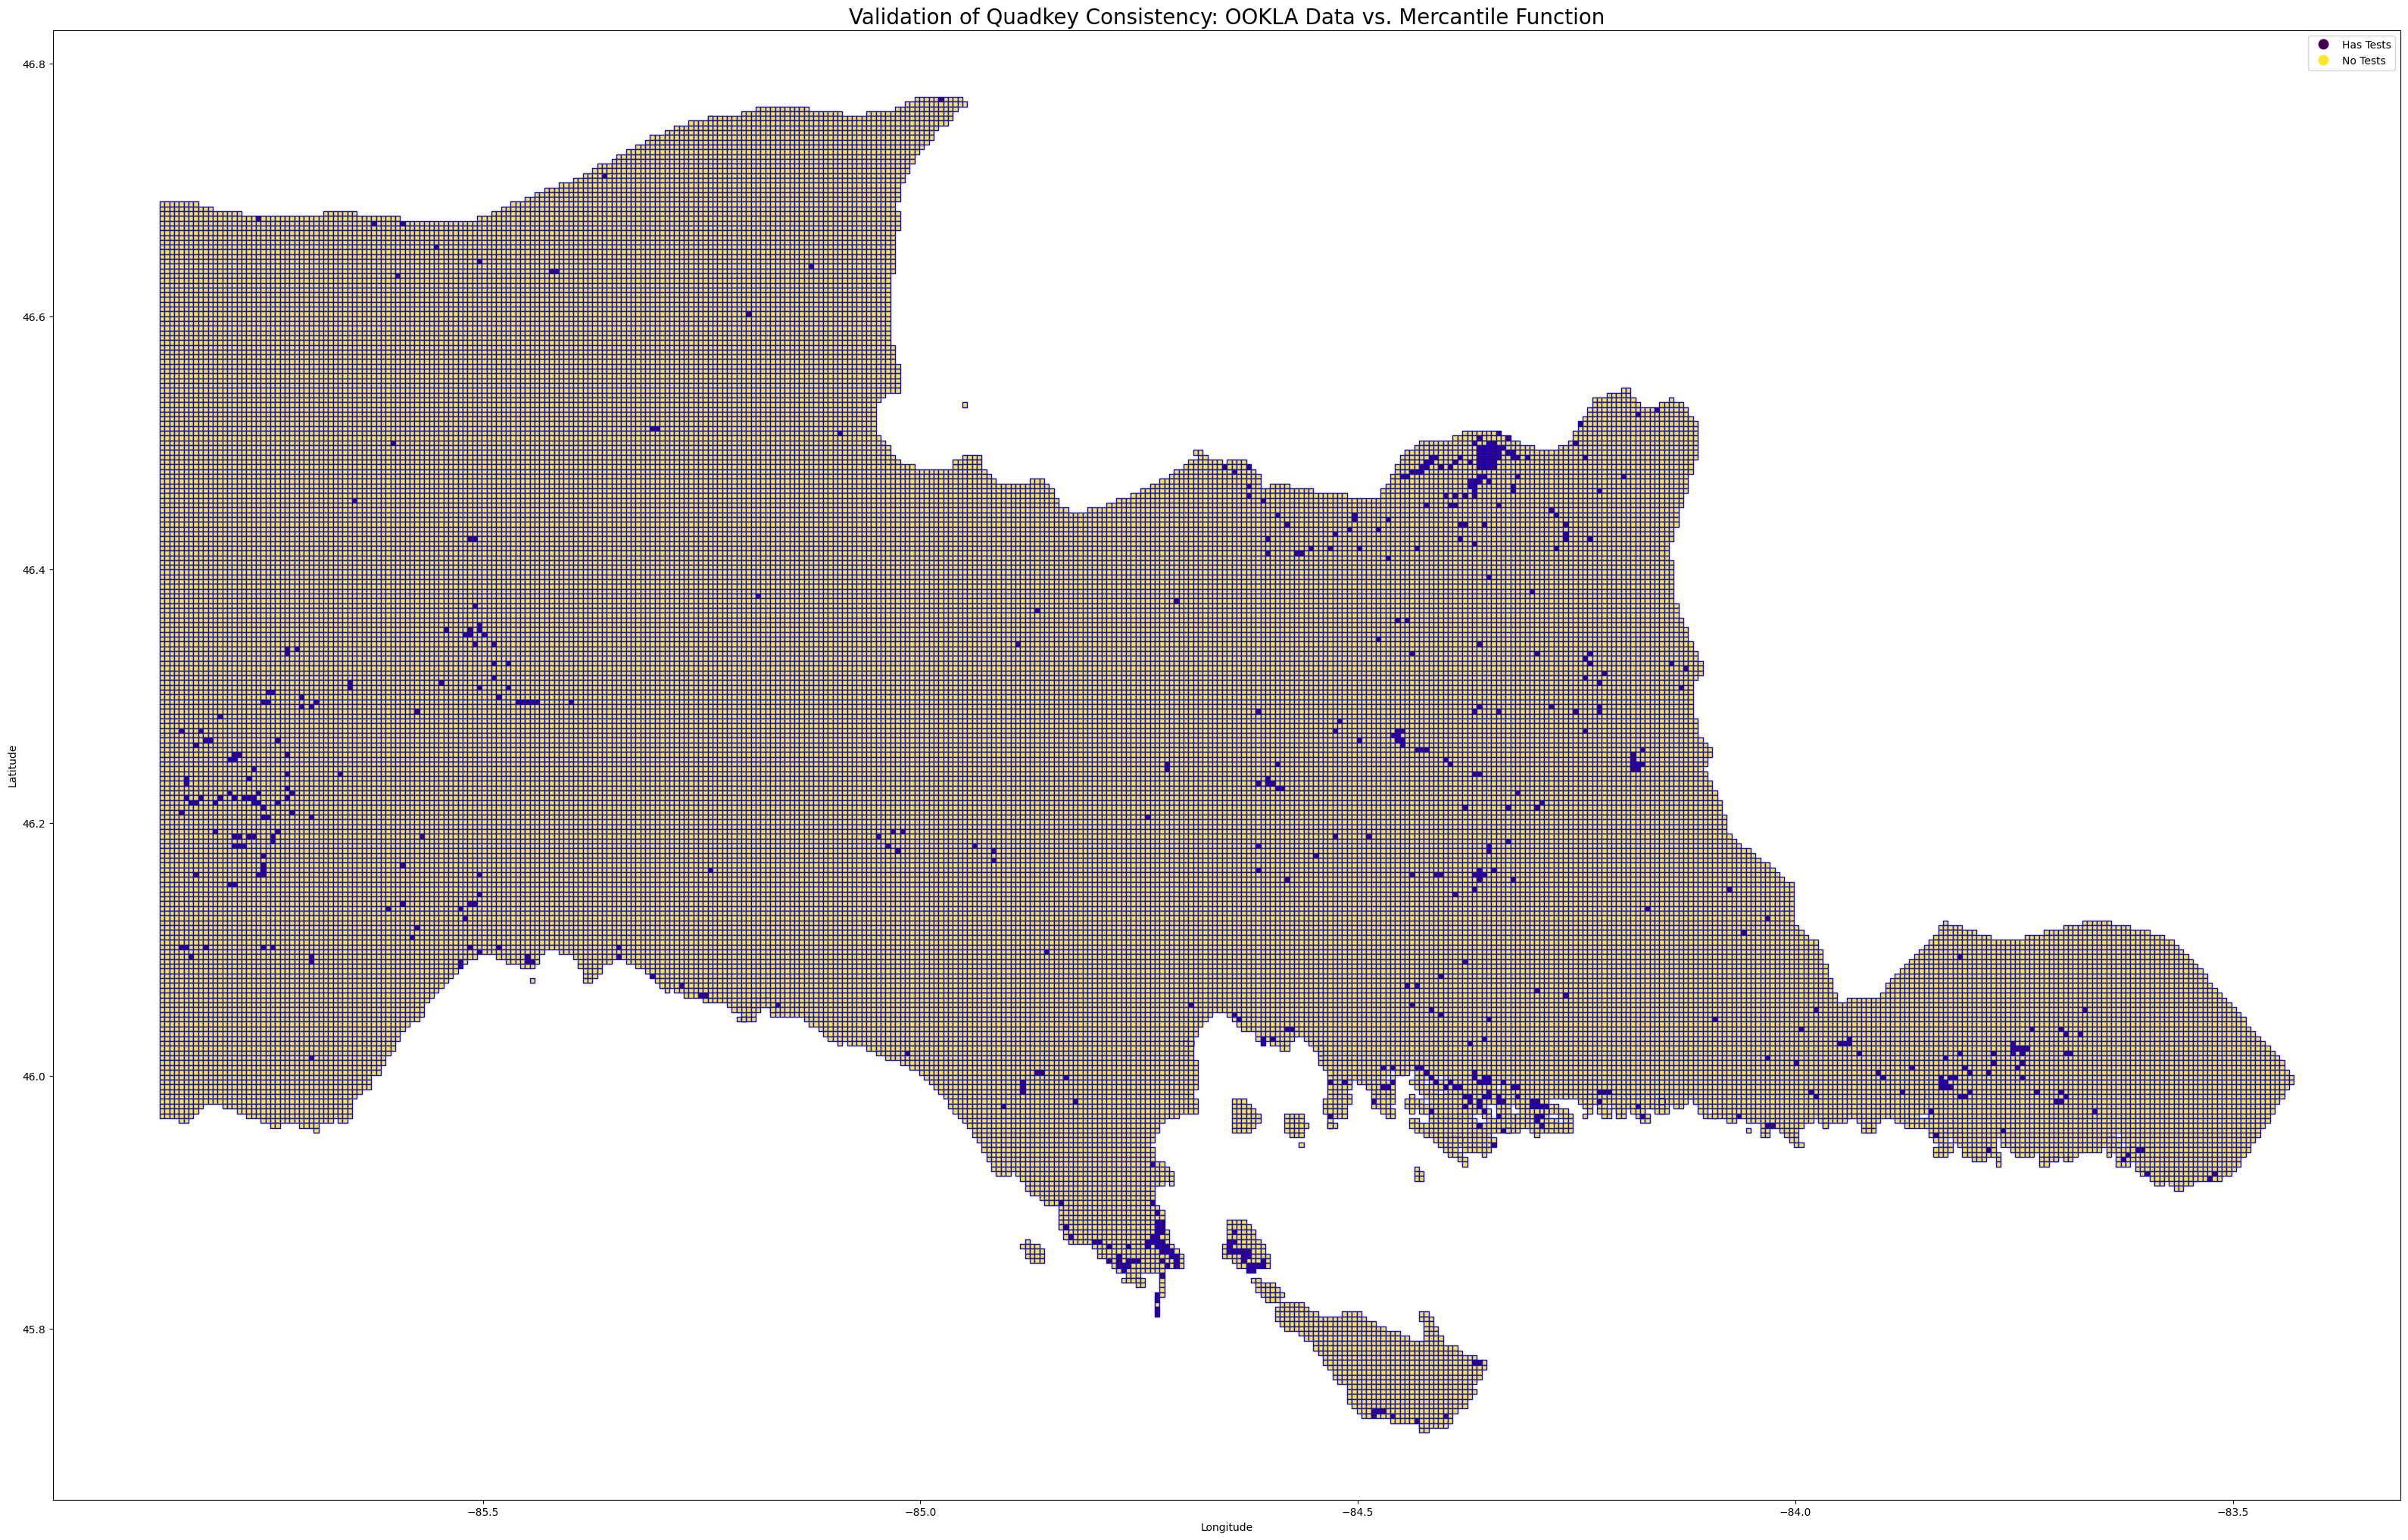

In [ ]:
# Convert the 'quadkey' column to int in both DataFrames
quadkey_gdf['quadkey'] = quadkey_gdf['quadkey'].astype(int)
ookla_tiles_df['quadkey'] = ookla_tiles_df['quadkey'].astype(int)


# Perform the left join based on the 'quadkey' column 
merged_df = quadkey_gdf.merge(ookla_tiles_df, on='quadkey', how='left')

# Convert the merged DataFrame back to a GeoDataFrame if needed
merged_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry')

# Compare the number of OOKLA tiles from the spatial join and the join on quadkey for validation

display(Markdown(f"## Number of OOKLA tiles from spatial join: {len(joined_gdf)}"))
display(Markdown(f"## Number of OOKLA tiles from join on quadkey: {merged_gdf['tests'].count()}"))

# Create a new column 'has_tests' based on the 'tests' column in the merged GeoDataFrame which comes from the OOKLA data
merged_gdf['has_tests'] = merged_gdf['tests'].apply(lambda x: 'No Tests' if pd.isna(x) else 'Has Tests')

# Plot the GeoDataFrame based on the 'has_tests' column to verify that the quadkey we calculated matches the quadkey in the OOKLA data

fig, ax = plt.subplots(1, 1, figsize=(40, 40))
merged_gdf.plot(column='has_tests', ax=ax, edgecolor='blue', legend=True, cmap='viridis')

# Set plot title and labels
ax.set_title('Validation of Quadkey Consistency: OOKLA Data vs. Mercantile Function', fontsize=20)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

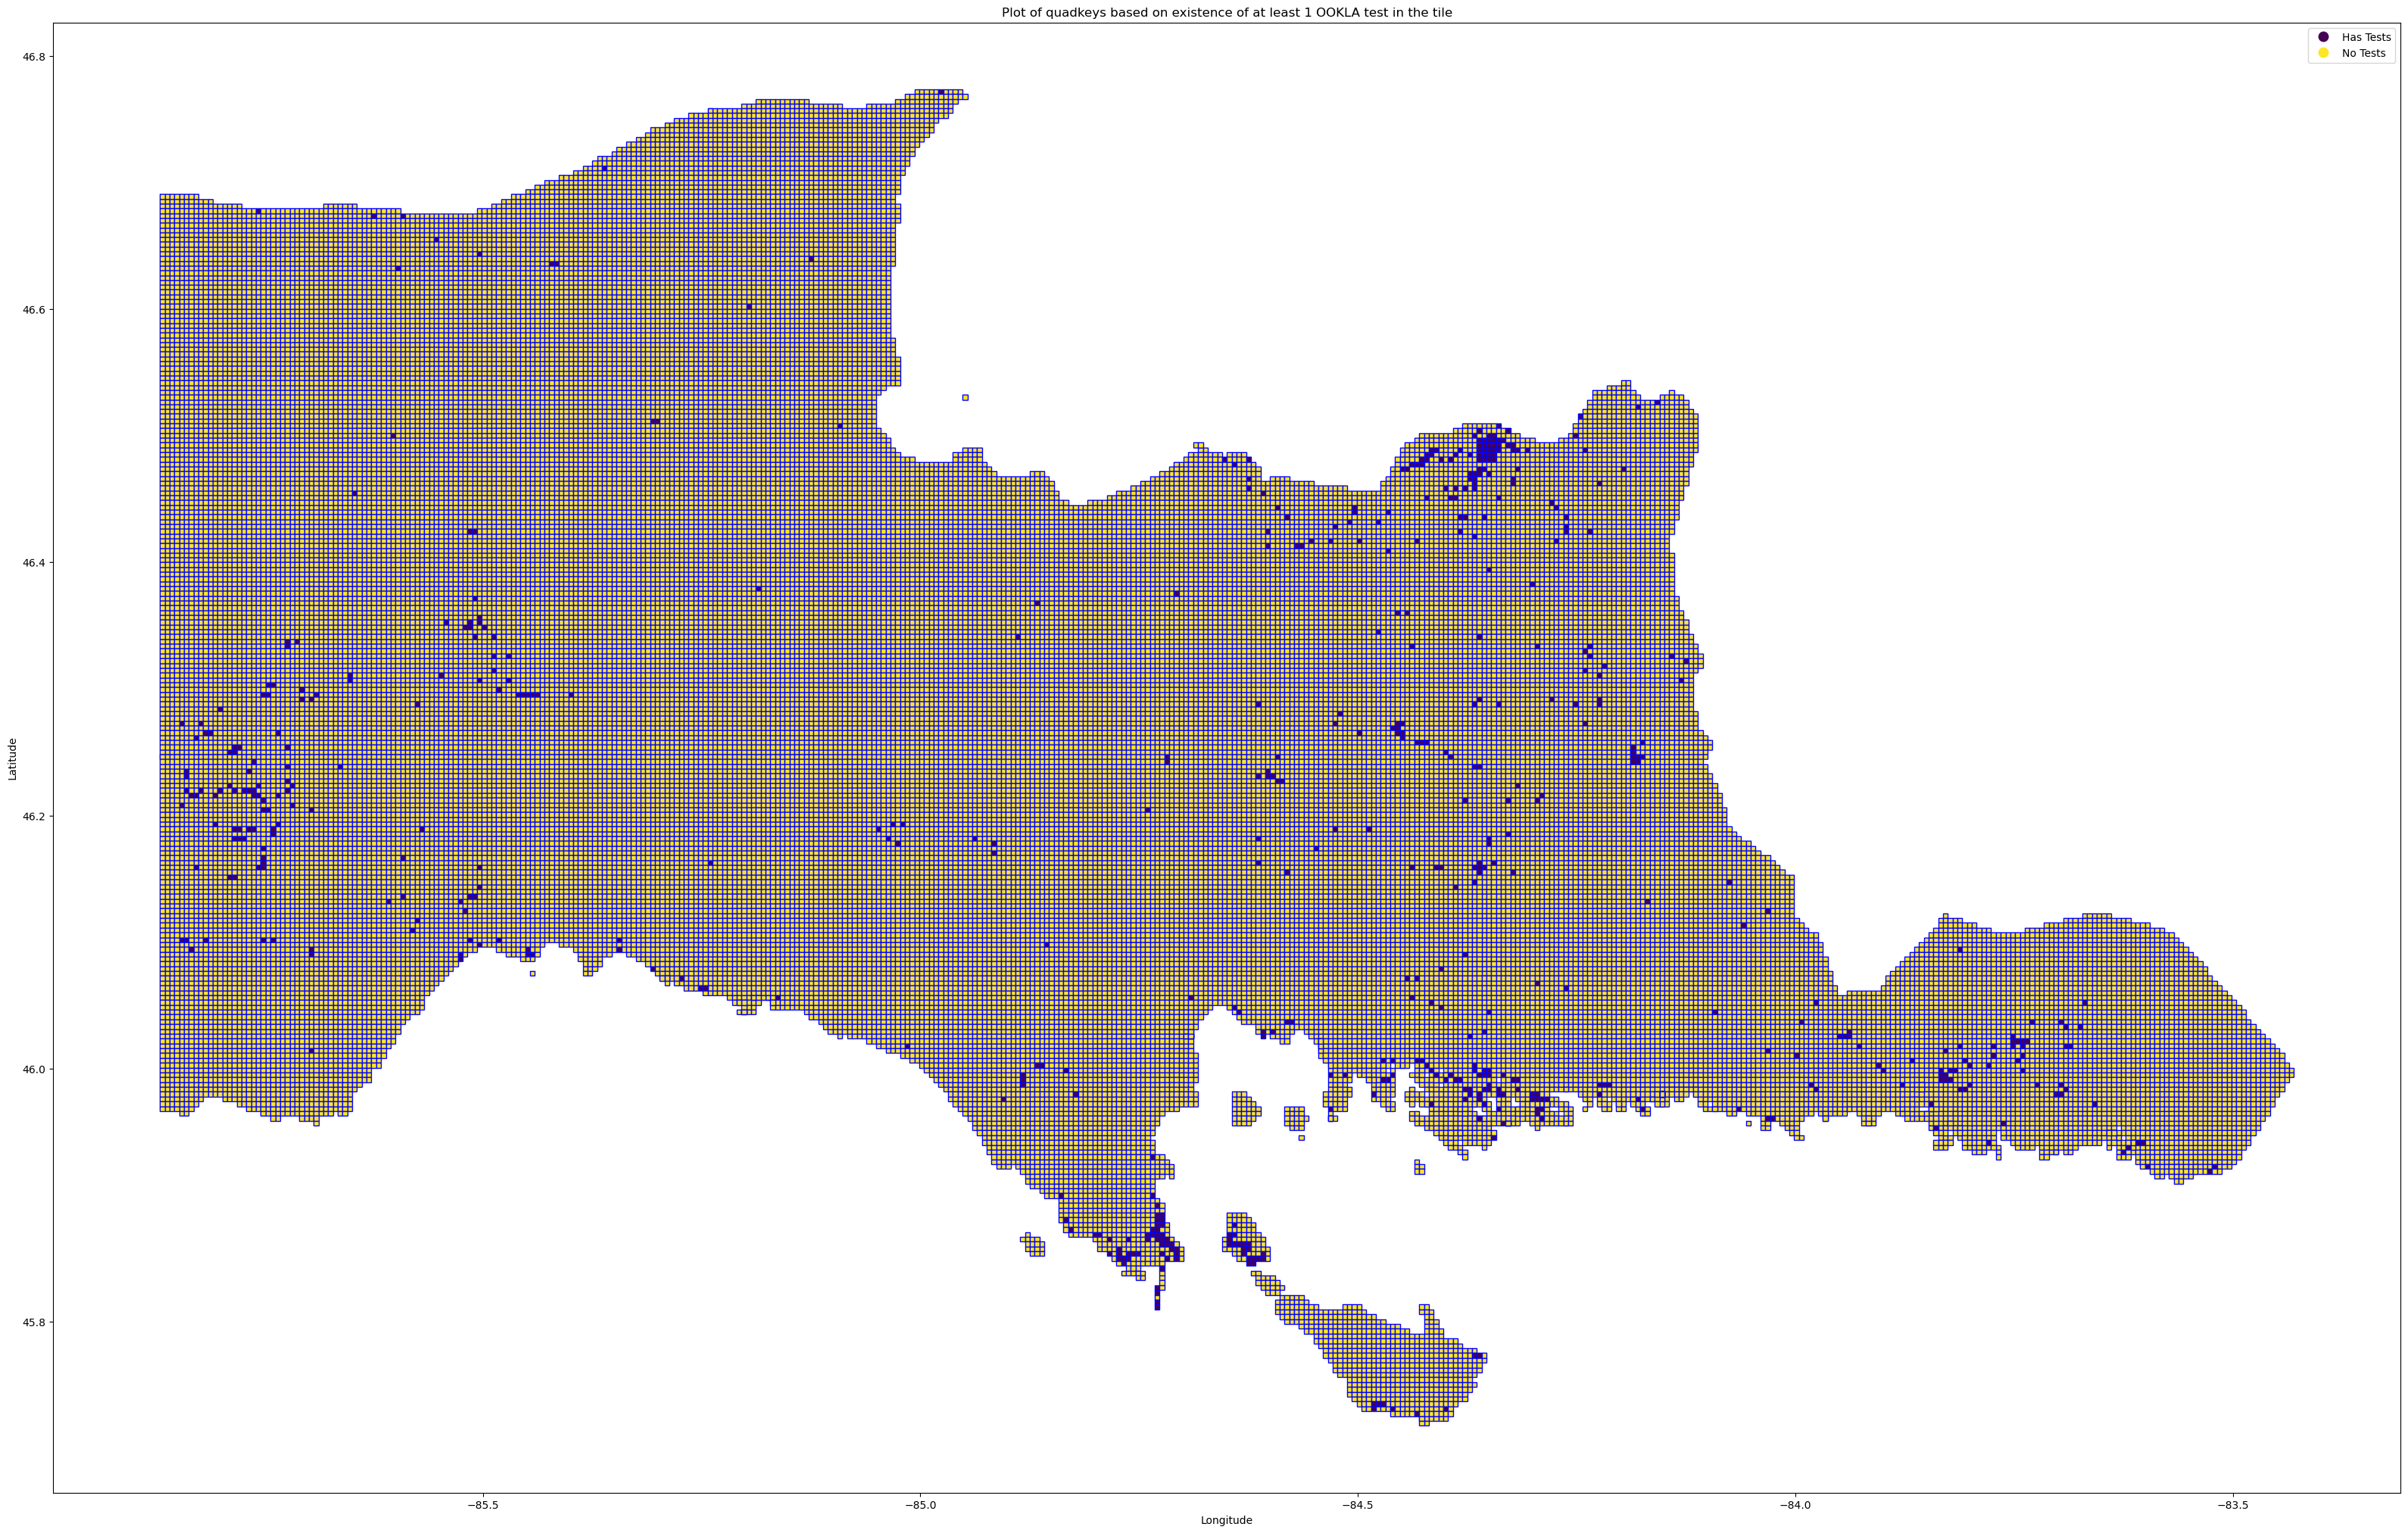